In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
import time

# Read the CSV file
df = pd.read_csv("iris.csv")

# Get the start time
start_time = time.time()


In [4]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
# map between integer label and categorical target

cat_map = dict(zip(df["species"].astype("category").cat.codes, df["species"]))
print("\nTarget integer-label encoding:", cat_map, "\n\n")

# categorical target --> integer label

df["species"] = df["species"].astype("category").cat.codes

#################################################################################

# taking only species 1 and 0 -- binary classification

df = df[df["species"].isin([0, 1])]

#################################################################################

df.info()


Target integer-label encoding: {0: 'setosa', 1: 'versicolor', 2: 'virginica'} 


<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  100 non-null    float64
 1   sepal_width   100 non-null    float64
 2   petal_length  100 non-null    float64
 3   petal_width   100 non-null    float64
 4   species       100 non-null    int8   
dtypes: float64(4), int8(1)
memory usage: 4.0 KB


In [6]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width,species
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,5.471000,3.099000,2.861000,0.786000,0.500000
std,0.641698,0.478739,1.449549,0.565153,0.502519
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.000000,2.800000,1.500000,0.200000,0.000000
50%,5.400000,3.050000,2.450000,0.800000,0.500000
75%,5.900000,3.400000,4.325000,1.300000,1.000000
max,7.000000,4.400000,5.100000,1.800000,1.000000


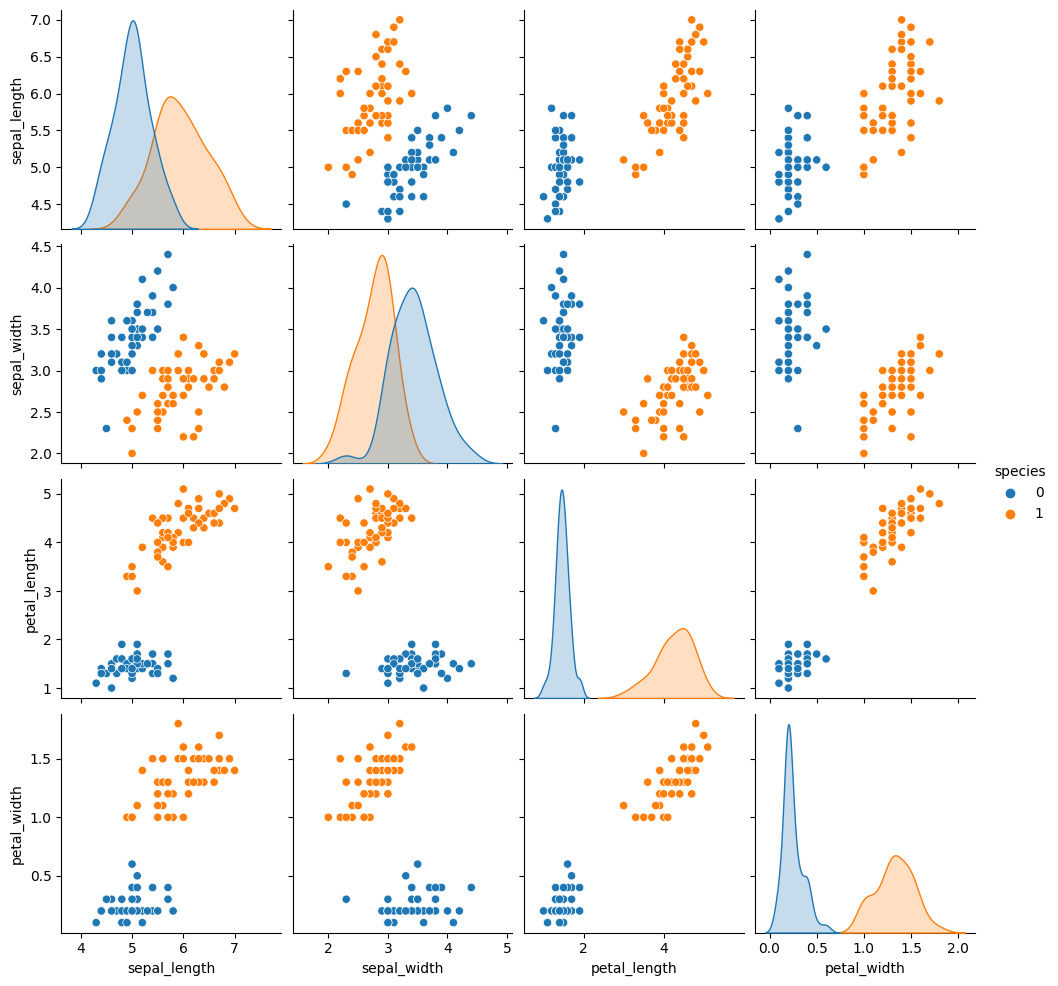

In [7]:
sns.pairplot(df, hue="species")

In [8]:
# features
X = df.drop(columns="species")
# target
y = df["species"]


In [9]:
# train-test split, 20% test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Create an imputer to replace NaN values with the mean
imputer = SimpleImputer(strategy='mean')

# Create a pipeline with the imputer and logistic regression
pipeline = Pipeline([
    ('imputer', imputer),
    ('logit', LogisticRegression(random_state=42))
])

# Fit the pipeline on your data
pipeline.fit(X, y)

# Predict using the trained model
y_pred = pipeline.predict(X_test)

# Print classification report and confusion matrix
print("Classical classifier (Logistic Regression):\n")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Classical classifier (Logistic Regression):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

[[10  0]
 [ 0 10]]


In [11]:
#Variational Quantum Classifier

In [12]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

In [13]:
# we'll encode each feature in a single qubit. Thus, that's the number of qubits

N = X.shape[1]


Initial Circuit:



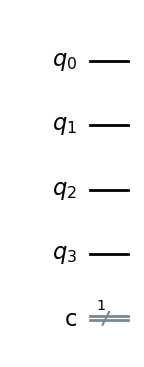

In [14]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
qr = QuantumRegister(N, "q")
cr = ClassicalRegister(1, "c")

qc = QuantumCircuit(qr, cr)

print("\nInitial Circuit:\n")

qc.draw("mpl")


In [15]:
# selecting one single observation

k = 0
obs_k = X_train.iloc[k]

In [16]:
obs_k

sepal_length    5.7
sepal_width     4.4
petal_length    1.5
petal_width     0.4
Name: 15, dtype: float64

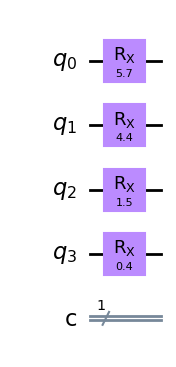

In [17]:
for i, phi_ik in enumerate(obs_k):
    
    qc.rx(phi_ik, i)
    
qc.draw("mpl")

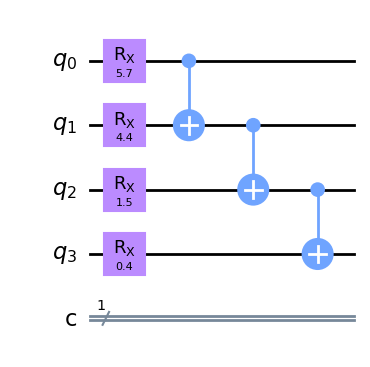

In [18]:
# CNOTs to induce entanglement

for i in range(N-1):
    
    qc.cnot(i, i+1)
    
qc.draw("mpl")

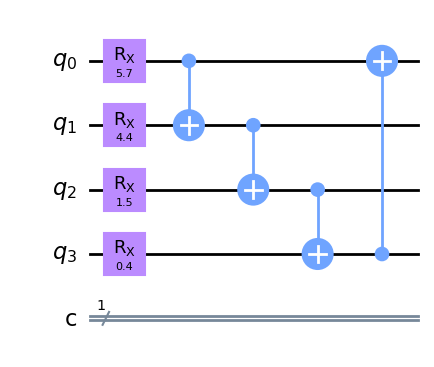

In [19]:
# CNOT, targeted on the first register

qc.cnot(N-1, 0)

qc.draw("mpl")

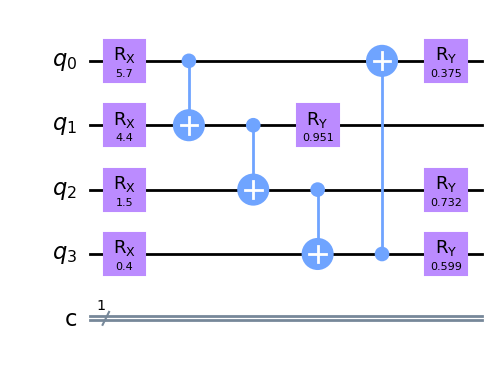

In [20]:
# parameterized rotations

# first, let's introduce a vector of (random) parameters. 
# that's the parameter vector \vec{\theta}

np.random.seed(42)
theta = np.random.uniform(0, 1, N)

for i in range(N):
    
    qc.ry(theta[i], i)
    
qc.draw("mpl")

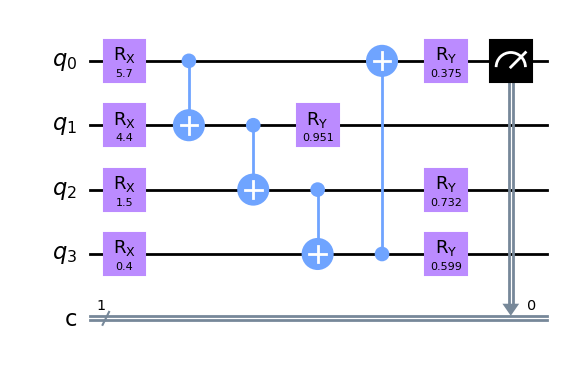

In [21]:
# measure the first qubit and put its readout in the classical register

qc.measure(0, cr)

qc.draw("mpl")

In [22]:
# import provider for simulator and define the simulator backend

from qiskit import Aer

backend = Aer.get_backend("qasm_simulator")

In [23]:
# defining the job and sending it to execute in the defined backend
# we will run the circuit a n_runs number of times
# we fix the simulator seed for reproducibility

n_runs = 1e3

from qiskit import execute

job = execute(qc, backend, shots=int(n_runs), seed_simulator=42)

In [24]:
# getting the results of the job execution

results = job.result()

results

Result(backend_name='qasm_simulator', backend_version='0.12.0', qobj_id='', job_id='6bd8a60f-d1a4-48f5-8e4b-ba4b91cf19d7', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 497, '0x1': 503}), header=QobjExperimentHeader(creg_sizes=[['c', 1]], global_phase=0.0, memory_slots=1, metadata=None, n_qubits=4, name='circuit-114', qreg_sizes=[['q', 4]]), status=DONE, seed_simulator=42, metadata={'batched_shots_optimization': False, 'method': 'statevector', 'active_input_qubits': [0, 1, 2, 3], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 4, 'num_clbits': 1, 'sample_measure_time': 0.0007132, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3]], 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 4, 'fusion': {'enabled': True, 'threshold': 14, 'max_fused_qubits': 5, 'applied': False}}, time_taken=0.002916)], date=2023-07-24T13:39:51.880521, status=COMPLETED, header=None, metadata

In [25]:
# To get the resulting counts (of measurements in the classical register),
# we use the get_counts() method

counts = results.get_counts()

counts

{'0': 497, '1': 503}

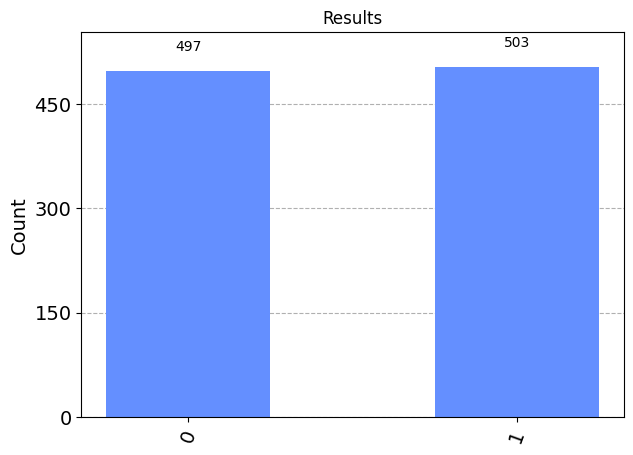

In [26]:
# ploting the counts above as a histogram

from qiskit.visualization import plot_histogram

plot_histogram(counts, title="Results")

In [27]:
p_y_k = counts["1"]/n_runs

p_y_k


0.503

In [28]:
p_y_k = counts["1"]/n_runs

p_y_k


0.503

In [29]:
y_train.iloc[k]

0

In [30]:
# functions for the circuit construction

def initialize_circuit(Nq, Nc):
    '''
    initializes a circuit with Nq quantum registers and Nc classical registers
    '''
    
    # quantum and classical registers
    qr = QuantumRegister(Nq, "q")
    cr = ClassicalRegister(Nc, "c")

    # quantum circuit
    qc = QuantumCircuit(qr, cr)

    return qc

In [31]:
def feature_map(qc, X_k):
    '''
    encodes classical data (in the array X) into the quantum circuit initial state.
    each component of the X array is encoded in the respective quantum register.
    the encoding is achieved via a Rx rotation, whose angle is the respective X component
    '''
    
    # data encoding with Rx rotations
    for i, phi_ik in enumerate(X_k):
    
        qc.rx(phi_ik, i)
        
    return qc

In [32]:
def variational_circuit(qc, theta):
    '''
    implements the variational portion of the quantum cirrcuit.
    the particular architecture will be: CNOTs between the registers;
    followed by parameterized Ry rotations (parameters defined by the argument "theta"); 
    '''
    
    # CNOTs to induce entanglement
    for i in range(N-1):
    
        qc.cnot(i, i+1)
        
    # final CNOT, targeted on the first register
    qc.cnot(N-1, 0)

    # parameterized rotations
    for i in range(N):

        qc.ry(theta[i], i)
        
    return qc
        

In [33]:
def measurement(qc):
    '''
    measure the first quantum register into the classical register
    '''
    
    qc.measure(0, -1)
    
    return qc

In [34]:
# full function to construct the circuit

def build_circuit(Nq, Nc, X, theta, k, show_circuit=True):
    '''
    construct and return the quantum circuit for the variational quantum classifier
    '''

    qc = initialize_circuit(Nq, Nc)
    
    feature_map(qc, X.iloc[k])
    
    variational_circuit(qc, theta)
    
    measurement(qc)
    
    if show_circuit:
        
        show_figure(qc.draw("mpl"))
        
    return qc

In [35]:
# functions for the circuit execution

def run_circuit(qc, simulator=True, backend_name = "qasm_simulator", n_runs=1000, seed_simulator=None):
    '''
    executes the quantum circuit in the specified backend (in the moment, it's just a simulator)
    TODO: allow for actual hardware
    the number of executions can also be specified.
    returns the results of the execution.
    '''
    
    if simulator:
        
        # import provider for simulator and define the simulator backend
        backend = Aer.get_backend(backend_name)
        
    else:
        
        pass
        # # todo: quantum hardware
        # backend = ...
        
    # defining the job and sending it to execute in the defined backend
    # we will run the circuit a n_runs number of times
    job = execute(qc, backend, shots=n_runs, seed_simulator=seed_simulator)
    
    # getting the results of the job execution
    results = job.result()
    
    return results


In [36]:
def show_figure(fig):
    '''
    auxiliar function to display plot 
    even if it's not the last command of the cell
    from: https://github.com/Qiskit/qiskit-terra/issues/1682
    '''
    
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)


In [37]:
def final_answer(results, thresh=0.5, n_runs=1000, visualize_results=False):
    '''
    calculate the probability of the observation belonging to class 1
    i.e., like the logit, calculation of P(y=1|x). 
    the actual class prediction is also calculated. both are returned.
    an optional visualization of the execution results as a histogram is also available
    '''

    # getting the resulting counts (of measurements in the classical register),
    counts = results.get_counts()
    
    if visualize_results:
        # ploting the counts as a histogram
        show_figure(plot_histogram(counts, title="Results"))
        
    # p(y=1 | x) - probability of observation belonging to class 1
    p_y = counts["1"]/n_runs
    
    # actual prediction, according to the specified threshold
    y_pred = 1 if p_y > thresh else 0
    
    return p_y, y_pred

In [38]:
# full vqc function (takes the quantum circuit as input and executes it)
def vqc(qc, simulator=True, backend_name="qasm_simulator", n_runs=1000,
        thresh=0.5, visualize_results=False, seed_simulator=None):

    '''
    this function integrates all the functions above in a single structure
    and returns p_y
    the only input is the integer k, used as an index for the chosen observation
    returns the final answer (probability and prediction)
    '''
    
    results = run_circuit(qc, seed_simulator=seed_simulator)

    return final_answer(results, visualize_results=visualize_results)

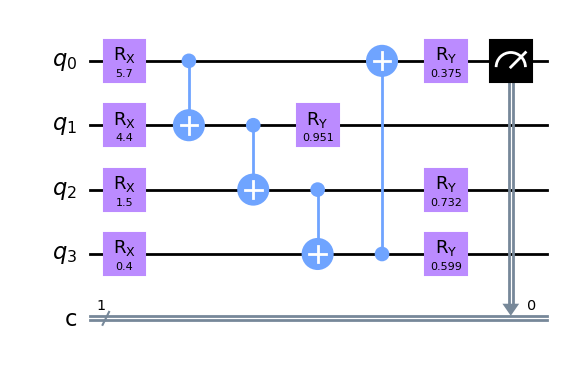

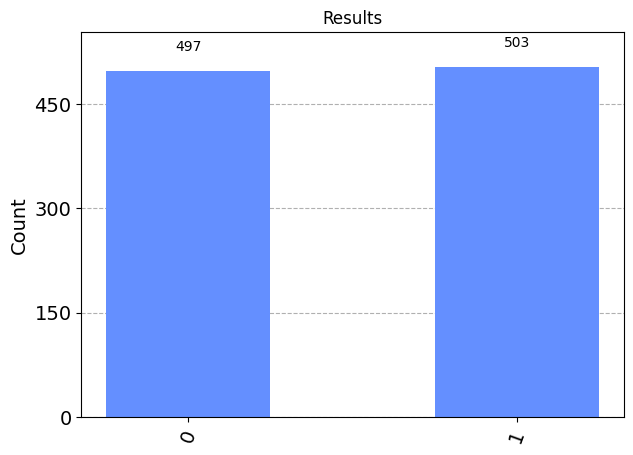

Predicted p(y=1|x) for the 0-th training observation: 0.503
Therefore, this observation is classified as 1


In [39]:
np.random.seed(42)
theta = np.random.uniform(0, 1, N)

qc = build_circuit(N, 1, X_train, theta, k=0, show_circuit=True)

p_y_k, y_pred_k = vqc(qc, seed_simulator=42, visualize_results=True)

print("Predicted p(y=1|x) for the " + str(k) + "-th training observation:", p_y_k)
print("Therefore, this observation is classified as", y_pred_k)


In [40]:
def loss_SE(p_y_k, y, k):
    '''
    computes the squared error (SE) loss
    '''
    
    return (p_y_k - y.iloc[k])**2

In [41]:
loss_SE(p_y_k, y_train, k)

0.253009

In [42]:
def gradient(N, X, y, k, p_y_k, theta, delta=5e-3, seed_simulator=None):   
    '''
    computes the directional derivative using the finite difference method
    '''
    
    theta_list = []
    for i in range(len(theta)):

        theta_list.append(theta.copy())
        theta_list[-1][i] = theta_list[-1][i] + delta
    
    del_theta = []
    
    for theta_pd in theta_list:
        
        # below, pd = "plus delta"
        
        qc_pd = build_circuit(N, 1, X, theta_pd, k, show_circuit=False)
        p_y_k_pd, _ = vqc(qc_pd, seed_simulator=seed_simulator)

        loss_theta = loss_SE(p_y_k, y, k)
        loss_theta_pd = loss_SE(p_y_k_pd, y, k)

        derivative = (loss_theta_pd - loss_theta)/delta

        del_theta.append(derivative)
        
    return np.array(del_theta)

In [43]:

def train_accuracy(y_pred_k, y, k):
    
    return 1 if y_pred_k == y.iloc[k] else 0


In [44]:
def stochastic_gd(N, X, y, theta, lr = 5e-2, num_epochs=50, show_progress=True, seed_simulator=None):
    
    loss_each_epoch = []
    accuracy_each_epoch = []
    
    if show_progress:
        print("Epoch \t Loss \t Training Accuracy")
    
    for n in range(num_epochs):
        
        loss_inter_epoch = []
        accuracy_inter_epoch = []
        
        for k in range(X.shape[0]):
        
            qc = build_circuit(N, 1, X, theta, k, show_circuit=False)

            p_y_k, y_pred_k = vqc(qc, seed_simulator=seed_simulator)
            
            loss_inter_epoch.append(loss_SE(p_y_k, y, k))
            
            accuracy_inter_epoch.append(train_accuracy(y_pred_k, y, k))
            
            theta = theta - lr * gradient(N, X, y, k, p_y_k, theta, seed_simulator=seed_simulator)
    
        loss_each_epoch.append(np.mean(loss_inter_epoch)) 
        accuracy_each_epoch.append(np.mean(accuracy_inter_epoch)) 
        
        if show_progress:
            print(n+1, "\t", round(loss_each_epoch[-1], 3), "\t", round(accuracy_each_epoch[-1], 3))
            
    return loss_each_epoch, accuracy_each_epoch, theta

In [45]:
N = X_train.shape[1]

np.random.seed(42)

theta = np.random.uniform(0, 2*np.pi, N)

# making a copy for later comparison
theta_0 = theta.copy()

num_epochs = 20

training_loss, training_accuracy, theta_final = stochastic_gd(N, X_train, y_train, theta,
                                                              lr =float(0.01), num_epochs=int(num_epochs), 
                                                              seed_simulator=42)

Epoch 	 Loss 	 Training Accuracy
1 	 0.217 	 0.825
2 	 0.217 	 0.812
3 	 0.217 	 0.825
4 	 0.217 	 0.812
5 	 0.215 	 0.812
6 	 0.214 	 0.838
7 	 0.214 	 0.838
8 	 0.214 	 0.85
9 	 0.214 	 0.838
10 	 0.213 	 0.825
11 	 0.214 	 0.825
12 	 0.213 	 0.812
13 	 0.213 	 0.812
14 	 0.213 	 0.812
15 	 0.213 	 0.812
16 	 0.212 	 0.812
17 	 0.212 	 0.812
18 	 0.212 	 0.812
19 	 0.211 	 0.825
20 	 0.211 	 0.825


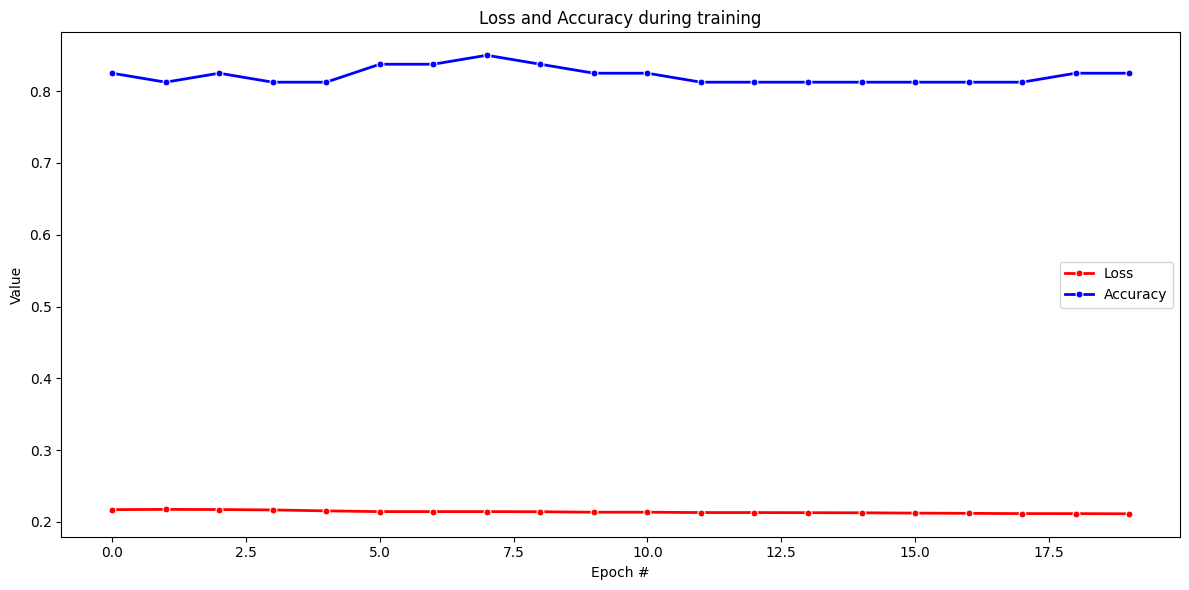

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have defined the 'training_loss' and 'training_accuracy' lists

plt.figure(figsize=(12, 6))

# Plot Loss and Accuracy on the same graph
sns.lineplot(x=range(len(training_loss)), y=training_loss, color="red", label="Loss",
             marker='o', markersize=5, linestyle='-', linewidth=2)
sns.lineplot(x=range(len(training_accuracy)), y=training_accuracy, color="blue", label="Accuracy",
             marker='o', markersize=5, linestyle='-', linewidth=2)

plt.xlabel("Epoch #")
plt.ylabel("Value")
plt.title("Loss and Accuracy during training")
plt.legend()

plt.tight_layout()
plt.show()


In [52]:

print("Final variational parameters vector:", theta_final)

print("\nMean training accuracy in the", num_epochs, "epochs:", np.mean(training_accuracy))

Final variational parameters vector: [2.62047497 5.97351416 4.59925358 3.76148219]

Mean training accuracy in the 20 epochs: 0.821875


In [50]:
y_pred = []

for k in range(X_test.shape[0]):
    
    qc = build_circuit(N, 1, X_test, theta_final, k, show_circuit=False)

    _, y_pred_k = vqc(qc, seed_simulator=42)
                      
    y_pred.append(y_pred_k)

In [51]:

print("Quantum classifier (VQC):\n")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

execution_time = time.time() - start_time

# Print the execution time
print("Execution time: {:.2f} seconds".format(execution_time))

Quantum classifier (VQC):

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

[[ 8  2]
 [ 0 10]]
Execution time: 408.75 seconds
